# Const

In [1]:
FOLDER = "images"

OLD_TRAIN_DIR = f"{FOLDER}/Жуковский образцы почерка"
TRAIN_DIR = f"{FOLDER}/train"

OLD_TEST_DIR = f"{FOLDER}/Конволюты"
TEST_DIR = f"{FOLDER}/test"

NEW_TRAIN_DIR = f"{FOLDER}/new_train"
NEW_TEST_DIR = f"{FOLDER}/new_test"
# IMG_SIZE = (3024, 4032)
IMG_SIZE = (192, 256)

DATA = "data"
DATA_TRAIN = f"{DATA}/train"
DATA_TEST = f"{DATA}/test"

BATCH_SIZE = 8

In [2]:
# (3024, 4032) -> (x, 256)
# 3024 * 256 / 4032
int(3024/4), int(4032/4)

(756, 1008)

# Библиотеки

In [3]:
import os
import re

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 900_000_000

import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision
from torchvision import datasets, models, transforms

# Папки train и test

In [2]:
!rm -r "$FOLDER"

In [3]:
!tree -a

.
├── data
│   ├── test
│   │   ├── 122-0.JPG
│   │   ├── 122-10.JPG
│   │   ├── 122-11.JPG
│   │   ├── 122-1.JPG
│   │   ├── 122-2.JPG
│   │   ├── 122-3.JPG
│   │   ├── 122-4.JPG
│   │   ├── 122-5.JPG
│   │   ├── 122-6.JPG
│   │   ├── 122-7.JPG
│   │   ├── 122-8.JPG
│   │   ├── 122-9.JPG
│   │   ├── 142-0.JPG
│   │   ├── 142-10.JPG
│   │   ├── 142-11.JPG
│   │   ├── 142-12.JPG
│   │   ├── 142-13.JPG
│   │   ├── 142-14.JPG
│   │   ├── 142-15.JPG
│   │   ├── 142-16.JPG
│   │   ├── 142-17.JPG
│   │   ├── 142-18.JPG
│   │   ├── 142-19.JPG
│   │   ├── 142-1.JPG
│   │   ├── 142-20.JPG
│   │   ├── 142-21.JPG
│   │   ├── 142-22.JPG
│   │   ├── 142-23.JPG
│   │   ├── 142-24.JPG
│   │   ├── 142-25.JPG
│   │   ├── 142-26.JPG
│   │   ├── 142-27.JPG
│   │   ├── 142-2.JPG
│   │   ├── 142-3.JPG
│   │   ├── 142-4.JPG
│   │   ├── 142-5.JPG
│   │   ├── 142-6.JPG
│   │   ├── 142-7.JPG
│   │   ├── 142-8.JPG
│   │   ├── 142-9.JPG
│   │   ├── 2013-0.JPG
│   │   ├── 2013-10.JPG
│   │   ├── 2013-11.JPG
│   │

In [4]:
!unzip 'Жуковский образцы почерка.zip' -d "$FOLDER"
!unzip 'Конволюты.zip' -d "$FOLDER"

Archive:  Жуковский образцы почерка.zip
   creating: images/Жуковский образцы почерка/
  inflating: images/Жуковский образцы почерка/.DS_Store  
  inflating: images/__MACOSX/Жуковский образцы почерка/._.DS_Store  
   creating: images/Жуковский образцы почерка/1 Ранний почерк/
   creating: images/Жуковский образцы почерка/2 Зрелый почерк/
   creating: images/Жуковский образцы почерка/3 Поздний почерк/
   creating: images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Протасовым (хороший почерк). 1 апреля 1814. ИРЛИ. Р. 1. Оп. 9. № 83/
  inflating: images/Жуковский образцы почерка/1 Ранний почерк/.DS_Store  
  inflating: images/__MACOSX/Жуковский образцы почерка/1 Ранний почерк/._.DS_Store  
  inflating: images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Тургеневу и Блудову (обычный почерк). 28 января 1807. РНБ. Ф. 286. Оп. 2. № 143.pdf  
  inflating: images/__MACOSX/Жуковский образцы почерка/1 Ранний почерк/._Жуковский к Тургеневу и Блудову (обы

In [5]:
!rm -r "$FOLDER"/__MACOSX

In [6]:
# удаление всех docx файлов
# https://recoverit.wondershare.com/file-recovery/linux-remove-directory-recursively.html
!find ./"$FOLDER" -type f -name '*.docx' -print -delete

./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.docx
./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676.docx
./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Плетневу и Вяземскому (плохой почерк). 1847. ИРЛИ. № 27763.docx
./images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Тургеневу и Блудову (обычный почерк). 28 января 1807. РНБ. Ф. 286. Оп. 2. № 143.docx
./images/Жуковский образцы почерка/1 Ранний почерк/Жуковский к Протасовым (хороший почерк). 1 апреля 1814. ИРЛИ. Р. 1. Оп. 9. № 83.docx
./images/Жуковский образцы почерка/2 Зрелый почерк/Жуковский к Воейковой (обычный почерк). 1821. ИРЛИ. Р. 3. Оп. 1. № 1109.docx
./images/Жуковский образцы почерка/2 Зрелый почерк/Жуковский к неизвестному (Вяземскому? плохой почерк). Б.д. ИРЛИ. № 2882.docx
./images/Жуковский образцы п

In [7]:
# удаление скрытых файлов
!find ./"$FOLDER" -type f -name '.*' -print -delete

./images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/.DS_Store
./images/Жуковский образцы почерка/3 Поздний почерк/.DS_Store
./images/Жуковский образцы почерка/1 Ранний почерк/.DS_Store
./images/Жуковский образцы почерка/2 Зрелый почерк/.DS_Store
./images/Жуковский образцы почерка/.DS_Store
./images/Конволюты/.DS_Store


In [8]:
!tree -a

.
├── data
│   ├── test
│   │   ├── 122-0.JPG
│   │   ├── 122-10.JPG
│   │   ├── 122-11.JPG
│   │   ├── 122-1.JPG
│   │   ├── 122-2.JPG
│   │   ├── 122-3.JPG
│   │   ├── 122-4.JPG
│   │   ├── 122-5.JPG
│   │   ├── 122-6.JPG
│   │   ├── 122-7.JPG
│   │   ├── 122-8.JPG
│   │   ├── 122-9.JPG
│   │   ├── 142-0.JPG
│   │   ├── 142-10.JPG
│   │   ├── 142-11.JPG
│   │   ├── 142-12.JPG
│   │   ├── 142-13.JPG
│   │   ├── 142-14.JPG
│   │   ├── 142-15.JPG
│   │   ├── 142-16.JPG
│   │   ├── 142-17.JPG
│   │   ├── 142-18.JPG
│   │   ├── 142-19.JPG
│   │   ├── 142-1.JPG
│   │   ├── 142-20.JPG
│   │   ├── 142-21.JPG
│   │   ├── 142-22.JPG
│   │   ├── 142-23.JPG
│   │   ├── 142-24.JPG
│   │   ├── 142-25.JPG
│   │   ├── 142-26.JPG
│   │   ├── 142-27.JPG
│   │   ├── 142-2.JPG
│   │   ├── 142-3.JPG
│   │   ├── 142-4.JPG
│   │   ├── 142-5.JPG
│   │   ├── 142-6.JPG
│   │   ├── 142-7.JPG
│   │   ├── 142-8.JPG
│   │   ├── 142-9.JPG
│   │   ├── 2013-0.JPG
│   │   ├── 2013-10.JPG
│   │   ├── 2013-11.JPG
│   │

In [9]:
# перевод pdf файлов в jpg
for dirpath, dirnames, filenames in os.walk(FOLDER):
    # print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")

    for fname in filenames:
        root, ext = os.path.splitext(fname) # ('Жуковский (обычный почерк)', '.pdf')
        fpath = os.path.join(dirpath, fname)

        if ext in {".jpeg", ".JPG", ".jpg"}:
            continue
        elif ext == ".pdf":
            print(f"--- Сonversion of '{fname}' ---")
            print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")
            # !echo "$fname"
            !pdftoppm -jpeg -r 600 "$fpath" "$dirpath"/"$root"
            !du -h "$fpath"
            !du -h "$dirpath"/"$root"-1.jpg
            !rm "$fpath"
        else:
            print("!!!!!!!!!!!!")

        print("\n")

--- Сonversion of 'Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.pdf' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк',
dirnames = ['Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676', 'Жуковский к Плетневу и Вяземскому (плохой почерк). 1847. ИРЛИ. № 27763'],
filenames = ['Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.pdf']

2,0M	images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1.pdf
5,2M	images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1-1.jpg


--- Сonversion of 'Жуковский к Тургеневу и Блудову (обычный почерк). 28 января 1807. РНБ. Ф. 286. Оп. 2. № 143.pdf' ---
dirpath = 'images/Жуковский образцы почерка/1 Ранний почерк',
dirnames = ['Жуковский к Протасовым (хороший почерк). 1 апреля 18

In [10]:
# есть в папке только файлы, то перенумеруем их

for dirpath, dirnames, filenames in os.walk(FOLDER):
    
    if len(dirnames) == 0: # если внутри нет папок
        for i, fname in enumerate(sorted(filenames)):
            _, ext = os.path.splitext(fname) # ('Жуковский (обычный почерк)', '.pdf')
            fpath = os.path.join(dirpath, fname)
            
            new_fpath = os.path.join(dirpath, str(i)) + ext

            print(f"--- Сonversion of '{fname}' to '{i}' ---")
            print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")
            
            !mv "$fpath" "$new_fpath"

        print("\n")

--- Сonversion of 'eaa0291_001_0008676_00001.JPG' to '0' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676',
dirnames = [],
filenames = ['eaa0291_001_0008676_00001.JPG', 'eaa0291_001_0008676_00005.JPG', 'eaa0291_001_0008676_00002.JPG', 'eaa0291_001_0008676_00004.JPG']

--- Сonversion of 'eaa0291_001_0008676_00002.JPG' to '1' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676',
dirnames = [],
filenames = ['eaa0291_001_0008676_00001.JPG', 'eaa0291_001_0008676_00005.JPG', 'eaa0291_001_0008676_00002.JPG', 'eaa0291_001_0008676_00004.JPG']

--- Сonversion of 'eaa0291_001_0008676_00004.JPG' to '2' ---
dirpath = 'images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676',
dirnames = [],
filenames = ['eaa0291_001_0008676_00001.JPG', 'e

## train

In [12]:
!rm -r "$TRAIN_DIR"

rm: cannot remove 'images/train': No such file or directory


In [13]:
!mkdir "$TRAIN_DIR"

In [14]:
# формирование train из Жуковский образцы почерка

for dirpath, dirnames, filenames in os.walk(OLD_TRAIN_DIR):
    # print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")

    for fname in filenames:
        _, ext = os.path.splitext(fname)
        fpath = os.path.join(dirpath, fname)

        # print(f"\n{dirpath = },\n{dirnames = },\n{filenames = },\n{fpath = }")

        splitpath = re.split(r"/", fpath) 
        # ['data', 'Жуковский образцы почерка', '3 Поздний почерк', 'Жуковский (обычный почерк).jpg']
        splitpath[-1] = os.path.splitext(splitpath[-1])[0] 
        # ['data', 'Жуковский образцы почерка', '3 Поздний почерк', 'Жуковский (обычный почерк)']
        
        for i, elem in enumerate(splitpath):
            inx_left_bracket = elem.find("(")
            inx_right_bracket = elem.rfind(")")

            if (inx_left_bracket != -1) and (inx_right_bracket != -1):
                splitpath[i] = elem[inx_left_bracket : inx_right_bracket + 1]

        new_fpath = os.path.join(TRAIN_DIR, "-".join(splitpath[2:])) + ext

        print(f"--- Copying of\n{fpath}\nto\n{new_fpath}\n---")

        !cp "$fpath" "$new_fpath"

--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к А.Я. Булгакову (обычный почерк). 1850. РНБ. Ф. 286. Оп. 2. № 86. Л. 1-1.jpg
to
images/train/3 Поздний почерк-(обычный почерк).jpg
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/1.JPG
to
images/train/3 Поздний почерк-(хороший почерк)-1.JPG
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/2.JPG
to
images/train/3 Поздний почерк-(хороший почерк)-2.JPG
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 8676/0.JPG
to
images/train/3 Поздний почерк-(хороший почерк)-0.JPG
---
--- Copying of
images/Жуковский образцы почерка/3 Поздний почерк/Жуковский к Головину (хороший почерк). 1845-1846. EAA. Ф. 291. Оп. 1. № 

## test

In [16]:
!rm -r "$TEST_DIR"

rm: cannot remove 'images/test': No such file or directory


In [17]:
!mkdir "$TEST_DIR"

In [18]:
# формирование test из Конволюты

for dirpath, dirnames, filenames in os.walk(OLD_TEST_DIR):
    # print(f"{dirpath = },\n{dirnames = },\n{filenames = }\n")

    for fname in filenames:
        _, ext = os.path.splitext(fname)
        fpath = os.path.join(dirpath, fname)

        splitpath = re.split(r"/", fpath)
        # ['data', 'Конволюты', 'РГИА. Ф. 472. Оп. 1. № 662. О жалованье', '4.JPG']
        splitpath[-1] = os.path.splitext(splitpath[-1])[0] 
        # ['data', 'Конволюты', 'РГИА. Ф. 472. Оп. 1. № 662. О жалованье', '4']

        # print(f"\n{fpath = },\n{splitpath = }\n")
        
        for i, elem in enumerate(splitpath):
            inx_left = elem.find("№")
            inx_right = elem.find(".", inx_left)
            inx_right_new = elem.find(" ", inx_left + 2) # РГИА. Ф. 722. Оп. 1. № 2013 О С5/27
            
            if inx_right == -1 or inx_right_new < inx_right:
                inx_right = inx_right_new
            
            if (inx_left != -1) and (inx_right != -1):
                splitpath[i] = elem[inx_left+2 : inx_right]

        new_fpath = os.path.join(TEST_DIR, "-".join(splitpath[2:])) + ext

        print(f"--- Copying of\n{fpath}\nto\n{new_fpath}\n---")

        !cp "$fpath" "$new_fpath"

--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/4.JPG
to
images/test/662-4.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/1.JPG
to
images/test/662-1.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/2.JPG
to
images/test/662-2.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/6.JPG
to
images/test/662-6.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/0.JPG
to
images/test/662-0.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/8.JPG
to
images/test/662-8.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/5.JPG
to
images/test/662-5.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/3.JPG
to
images/test/662-3.JPG
---
--- Copying of
images/Конволюты/РГИА. Ф. 472. Оп. 1. № 662. О жалованье/7.JPG
to
images/test/662-7.JPG
---
--- Copying of
images/Конволюты/РГИА.

## new_train (resize train)

In [17]:
!tree -L 2

.
├── images
│   ├── test
│   ├── train
│   ├── Жуковский образцы почерка
│   └── Конволюты
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

5 directories, 3 files


In [16]:
!rm -r "$NEW_TRAIN_DIR"

In [18]:
!mkdir "$NEW_TRAIN_DIR"

In [19]:
# https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size[0] - img.size[0]
    delta_height = desired_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)


def resize_with_padding(img, expected_size):
    img.thumbnail(expected_size)
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [20]:
def open_image(image):
    # чтобы изображение не поворачивалось на 90 градусов, если w < h
    # https://stackoverflow.com/questions/4228530/pil-thumbnail-is-rotating-my-image
    img = Image.open(image)
    img = ImageOps.exif_transpose(img) 
    return img

In [21]:
train_files = sorted(os.listdir(path=TRAIN_DIR))
test_files = sorted(os.listdir(path=TEST_DIR))

In [22]:
for name in train_files[:5]:
    img = open_image(os.path.join(TRAIN_DIR, name))
    w, h = img.size
    print(f"{name:60} - {w} x {h}")

1 Ранний почерк-(обычный почерк).jpg                       - 21334 x 10242
1 Ранний почерк-(хороший почерк)-0.jpg                     - 1962 x 1169
1 Ранний почерк-(хороший почерк)-1.jpg                     - 2274 x 2941
1 Ранний почерк-(хороший почерк)-2.jpg                     - 2274 x 2941
1 Ранний почерк-(хороший почерк)-3.jpg                     - 2286 x 1564


In [23]:
for name in test_files[:5]:
    img = open_image(os.path.join(TEST_DIR, name))
    w, h = img.size
    print(f"{name:13} - {w} x {h}")

122-0.JPG     - 3024 x 4032
122-1.JPG     - 3024 x 4032
122-10.JPG    - 3024 x 4032
122-11.JPG    - 3024 x 4032
122-2.JPG     - 3024 x 4032


In [24]:
# resize в папку NEW_TRAIN_DIR
for name in train_files:
    img = open_image(os.path.join(TRAIN_DIR, name))
    size_old = img.size    
    img = resize_with_padding(img, IMG_SIZE)
    
    img.save(os.path.join(NEW_TRAIN_DIR, name))

    print(f"{size_old} \t-> {img.size}")

(21334, 10242) 	-> (192, 256)
(1962, 1169) 	-> (192, 256)
(2274, 2941) 	-> (192, 256)
(2274, 2941) 	-> (192, 256)
(2286, 1564) 	-> (192, 256)
(854, 625) 	-> (192, 256)
(1052, 1165) 	-> (192, 256)
(1440, 869) 	-> (192, 256)
(1440, 853) 	-> (192, 256)
(1440, 1671) 	-> (192, 256)
(1440, 858) 	-> (192, 256)
(1904, 2601) 	-> (192, 256)
(2152, 1448) 	-> (192, 256)
(2293, 1598) 	-> (192, 256)
(1607, 2488) 	-> (192, 256)
(21334, 10325) 	-> (192, 256)
(3992, 3156) 	-> (192, 256)
(3992, 3156) 	-> (192, 256)
(3992, 3156) 	-> (192, 256)
(2214, 3683) 	-> (192, 256)
(5616, 3744) 	-> (192, 256)
(5616, 3744) 	-> (192, 256)
(5616, 3744) 	-> (192, 256)


In [25]:
# img = open_image(os.path.join(TRAIN_DIR, train_files[5]))
# print(img.size)
# img
# width, height = im.size
# im = im.resize((100, 300))
# im

In [26]:
# img.thumbnail((1000, 1000))
# print(img.size)
# img

## new_test (resize test)

In [27]:
!tree -L 2

.
├── images
│   ├── new_train
│   ├── test
│   ├── train
│   ├── Жуковский образцы почерка
│   └── Конволюты
├── Zhukovsky.ipynb
├── Жуковский образцы почерка.zip
└── Конволюты.zip

6 directories, 3 files


In [28]:
!rm -r "$NEW_TEST_DIR"

rm: cannot remove 'images/new_test': No such file or directory


In [29]:
!mkdir "$NEW_TEST_DIR"

In [30]:
# resize в папку NEW_TEST_DIR
for name in test_files:
    img = open_image(os.path.join(TEST_DIR, name))
    size_old = img.size    
    img = resize_with_padding(img, IMG_SIZE)
    
    img.save(os.path.join(NEW_TEST_DIR, name))

    # print(f"{size_old} \t-> {img.size}")

(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (192, 256)
(3024, 4032) 	-> (19

## data

In [35]:
!rm -r "$DATA"

In [36]:
! mkdir "$DATA"

In [37]:
!cp -r "$NEW_TRAIN_DIR" "$DATA_TRAIN"

In [38]:
!cp -r "$NEW_TEST_DIR" "$DATA_TEST"

# Dataloader

In [34]:
# https://stackoverflow-com.translate.goog/questions/51677788/data-augmentation-in-pytorch?_x_tr_sl=auto&_x_tr_tl=ru&_x_tr_hl=ru

# from torch.utils.data import Dataset

# class experimental_dataset(Dataset):

#     def __init__(self, data, transform):
#         self.data = data
#         self.transform = transform

#     def __len__(self):
#         return len(self.data.shape[0])

#     def __getitem__(self, idx):
#         item = self.data[idx]
#         item = self.transform(item)
#         return item

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor()
# ])

# x = torch.rand(8, 1, 2, 2)
# print(x)

# dataset = experimental_dataset(x, transform)

# for item in dataset:
#     print(item)


In [4]:
def pos_neg(dataloader):
    num_pos = num_neg = num = 0

    for batch in dataloader:
        images, labels = batch
    
        col = images.size(0)
        pos = labels.sum()
        # print(images.size(0))
        
        num += col
        num_pos += pos
        num_neg += col - pos
    
    return num_pos, num_neg, num

In [36]:
tranf = transforms.Compose([
        # transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
        # transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
        # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
        transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
    ])

In [37]:
dataset = datasets.ImageFolder(DATA, transform=tranf)
len(dataset)

247

In [38]:
dataset[0]

(tensor([[[0.2000, 0.2000, 0.2000,  ..., 0.2353, 0.2353, 0.2353],
          [0.2078, 0.2078, 0.2078,  ..., 0.2353, 0.2353, 0.2353],
          [0.2078, 0.2078, 0.2118,  ..., 0.2353, 0.2353, 0.2353],
          ...,
          [0.1686, 0.0549, 0.0392,  ..., 0.0118, 0.0078, 0.0431],
          [0.1765, 0.0000, 0.2275,  ..., 0.0235, 0.0196, 0.0314],
          [0.2431, 0.0000, 0.0039,  ..., 0.0471, 0.0314, 0.0039]],
 
         [[0.1804, 0.1804, 0.1804,  ..., 0.1843, 0.1843, 0.1843],
          [0.1804, 0.1804, 0.1804,  ..., 0.1843, 0.1843, 0.1843],
          [0.1765, 0.1765, 0.1804,  ..., 0.1843, 0.1843, 0.1843],
          ...,
          [0.1686, 0.0549, 0.0392,  ..., 0.0078, 0.0039, 0.0392],
          [0.1765, 0.0000, 0.2275,  ..., 0.0196, 0.0157, 0.0275],
          [0.2431, 0.0000, 0.0039,  ..., 0.0431, 0.0275, 0.0000]],
 
         [[0.1059, 0.1059, 0.1059,  ..., 0.1176, 0.1176, 0.1176],
          [0.1059, 0.1059, 0.1059,  ..., 0.1176, 0.1176, 0.1176],
          [0.0941, 0.0941, 0.0980,  ...,

In [22]:
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
len(loader)

31

In [98]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(dataset) * 0.8)
# в валидационную — остальные 20%
val_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(
                    dataset, [train_size, val_size])

len(train_dataset), len(test_dataset)

(197, 50)

In [99]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(test_loader)

(25, 7)

In [101]:
inf_train = pos_neg(train_loader)
inf_train

(tensor(19), tensor(178), 197)

In [102]:
inf_test = pos_neg(test_loader)
inf_test

(tensor(4), tensor(46), 50)

In [114]:
images, labels = next(iter(train_loader))
print(images.shape, labels)

torch.Size([8, 3, 256, 192]) tensor([0, 0, 0, 0, 0, 0, 0, 0])


In [115]:
def show_images(images, labels):
    f, axes= plt.subplots(1, BATCH_SIZE//2, figsize=(30,10))
    
    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы) 
        img = np.transpose(img, (1, 2, 0))

        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

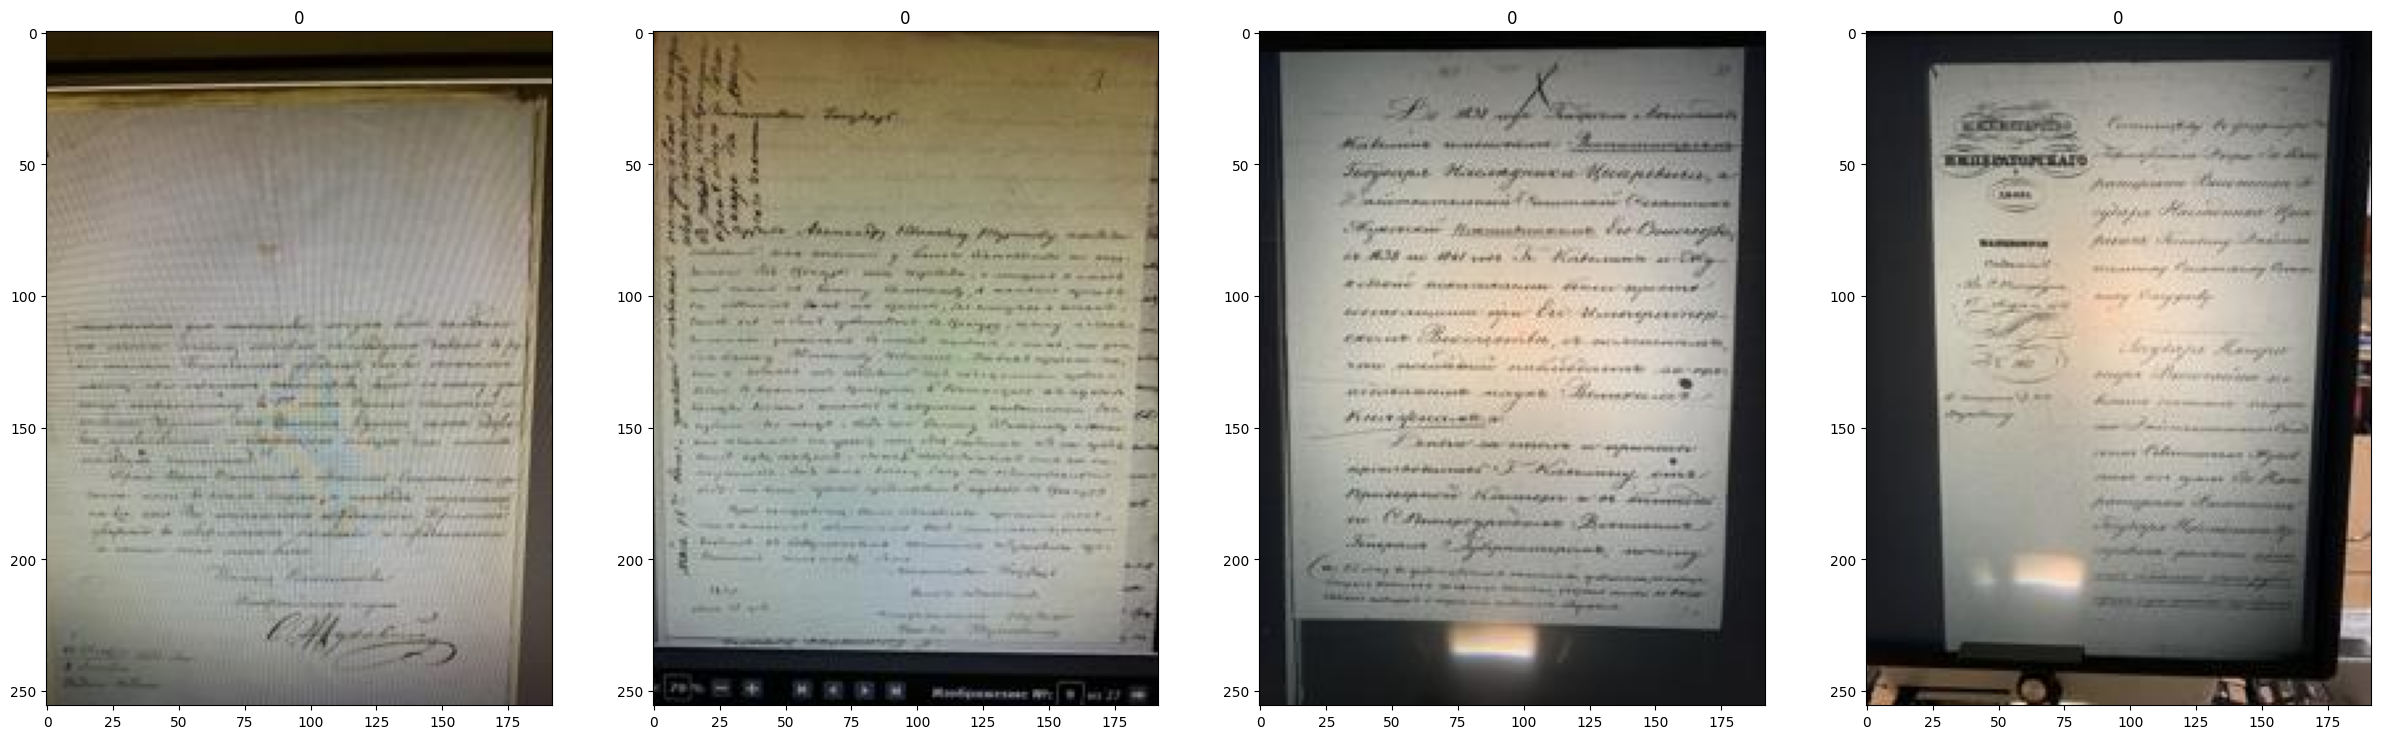

In [116]:
show_images(images, labels)

# evaluate train

In [125]:
def evaluate(model, dataloader, loss_fn):

    losses = []

    num_correct = 0
    num_elements = 0

    for i, batch in enumerate(dataloader):

        # получаем текущий батч
        X_batch, y_batch = batch
        num_elements += len(y_batch)

        # эта строка запрещает вычисление градиентов
        with torch.no_grad():
            # получаем ответы сети на картинки батча
            logits = model(X_batch.to(device))

            # вычисляем лосс на текущем батче
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())

            # вычисляем ответы сети как номера классов для каждой картинки
            y_pred = torch.argmax(logits, dim=1)

            # вычисляем количество правильных ответов сети в текущем батче
            num_correct += torch.sum(y_pred.cpu() == y_batch)

    # вычисляем итоговую долю правильных ответов
    accuracy = num_correct / num_elements

    return accuracy.numpy(), np.mean(losses)

def train(model, train_loader, val_loader, loss_fn, optimizer, n_epoch=3):

    # цикл обучения сети
    for epoch in range(n_epoch):

        print("Epoch:", epoch+1)

        model.train(True)

        running_losses = []
        running_accuracies = []
        for i, batch in enumerate(train_loader):
            # получаем текущий батч
            X_batch, y_batch = batch

            # forward pass (получение ответов на батч картинок)
            logits = model(X_batch.to(device))

            # вычисление лосса от выданных сетью ответов и правильных ответов на батч
            loss = loss_fn(logits, y_batch.to(device))
            running_losses.append(loss.item())

            loss.backward() # backpropagation (вычисление градиентов)
            optimizer.step() # обновление весов сети
            optimizer.zero_grad() # обнуляем веса

            # вычислим accuracy на текущем train батче
            model_answers = torch.argmax(logits, dim=1)
            train_accuracy = torch.sum(y_batch == model_answers.cpu()) / len(y_batch)
            running_accuracies.append(train_accuracy)

            # Логирование результатов
            if (i+1) % 50 == 0:
                print("Средние train лосс и accuracy на последних 50 итерациях:",
                      np.mean(running_losses), np.mean(running_accuracies), end='\n')

        # после каждой эпохи получаем метрику качества на валидационной выборке
        model.train(False)

        val_accuracy, val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print("Эпоха {}/{}: val лосс и accuracy:".format(epoch+1, n_epoch,),
                      val_loss, val_accuracy, end='\n')

    return model

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [123]:
# ВАШ КОД: постройте и обучите нейросеть
# model.children() выдает список сабмодулей нейросети
# в нашем случае это блоки resnet
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 2
print(f"Число классов: {num_classes}")

def create_model(model, num_freeze_layers, num_out_classes):
    # замена последнего слоя сети
    model.fc = nn.Linear(512, num_out_classes)

    # заморозка слоев
    for i, layer in enumerate(model.children()):
        if i < num_freeze_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model

Число слоёв: 10
Число классов: 2


In [126]:
# model = create_model(models.resnet18(pretrained=True), num_l - 1, num_classes)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model = create_model(model, num_layers - 1, num_classes).to(device)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, train_loader, test_loader, loss_fn, optimizer, n_epoch=20)

Epoch: 1
Эпоха 1/20: val лосс и accuracy: 0.2929168130670275 0.92
Epoch: 2
Эпоха 2/20: val лосс и accuracy: 0.25000319523470743 0.92
Epoch: 3
Эпоха 3/20: val лосс и accuracy: 0.23540189010756357 0.92
Epoch: 4
Эпоха 4/20: val лосс и accuracy: 0.22416760985340392 0.92
Epoch: 5
Эпоха 5/20: val лосс и accuracy: 0.21435250022581645 0.92
Epoch: 6
Эпоха 6/20: val лосс и accuracy: 0.1949382270021098 0.92
Epoch: 7
Эпоха 7/20: val лосс и accuracy: 0.18538963049650192 0.92
Epoch: 8
Эпоха 8/20: val лосс и accuracy: 0.17687385688935006 0.92
Epoch: 9
Эпоха 9/20: val лосс и accuracy: 0.16351555766803877 0.92
Epoch: 10
Эпоха 10/20: val лосс и accuracy: 0.15162698552012444 0.92
Epoch: 11
Эпоха 11/20: val лосс и accuracy: 0.13500017725995608 0.92
Epoch: 12
Эпоха 12/20: val лосс и accuracy: 0.1292713417538575 0.92
Epoch: 13
Эпоха 13/20: val лосс и accuracy: 0.1271374975996358 0.92
Epoch: 14
Эпоха 14/20: val лосс и accuracy: 0.11435650821243014 0.96
Epoch: 15
Эпоха 15/20: val лосс и accuracy: 0.1068455598

In [128]:
def get_predictions(model, dataloader):
    model.eval()
    predicted_labels = []
    true_labels = []

    for i, batch in enumerate(dataloader):

        # так получаем текущий батч
        X_batch, y_batch = batch
        true_labels.append(y_batch)

        with torch.no_grad():
            logits = model(X_batch.to(device))
            y_pred = torch.argmax(logits, dim=1)
            predicted_labels.append(y_pred)
            
    predicted_labels = torch.cat(predicted_labels)
    true_labels = torch.cat(true_labels)
    return predicted_labels, true_labels

In [138]:
y_pred, y_true = get_predictions(model, train_loader)
(y_pred == y_true).float().mean()

tensor(0.9746)

In [139]:
y_pred, y_true = get_predictions(model, test_loader)
(y_pred == y_true).float().mean()

tensor(0.9800)

In [151]:
y_pred, y_true = get_predictions(model, loader)
(y_pred == y_true).float().mean()

tensor(0.9757)

In [152]:
((y_pred == 1) * (y_true == 1)).float().sum()

tensor(17.)

In [153]:
((y_pred == 0) * (y_true == 1)).float().sum()

tensor(6.)

In [154]:
((y_pred == 0) * (y_true == 0)).float().sum()

tensor(224.)

In [155]:
((y_pred == 1) * (y_true == 0)).float().sum()

tensor(0.)